This section imports all the necessary libraries and packages for our deep learning pipeline.

In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet169
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from tqdm import tqdm
import warnings
import random

warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Here we define all the hyperparameters that control the training process and model behavior.

In [ ]:
# Define Hyperparameters
hyperparams = {
    "batch_size": 32,
    "learning_rate": 0.0001,
    "checkpoint_path": "checkpoint.pth",
    "best_model_path": "best_model.pth",  # New path for best model
    "hyperparam_file": "hyperparams.txt",
    "train_data_path": "/home/ragavpn/Desktop/HYPOTHESIS/CODING/PROJECTS/BHEL/Dataset/Train",  # Update with actual dataset path
    "train_split": 0.8  # 80% training, 20% testing
}

This class handles loading our X-ray images and their corresponding labels from the directory structure. It creates two types of labels:
Full classification labels (which specific class the image belongs to)
Binary anomaly labels (0 for "No Anomaly", 1 for any type of anomaly)

In [5]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.anomaly_labels = []  # Binary labels: 0 for No Anomaly, 1 for any anomaly

        # Get class names dynamically from subfolders
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.num_classes = len(self.classes)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        # Find index of "No Anomaly" class
        self.no_anomaly_idx = self.class_to_idx.get("No Anomaly", -1)
        
        # Get anomaly class names (excluding "No Anomaly")
        self.anomaly_classes = [cls for cls in self.classes if cls != "No Anomaly"]
        self.num_anomaly_classes = len(self.anomaly_classes)
        self.anomaly_class_to_idx = {cls: i for i, cls in enumerate(self.anomaly_classes)}

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.image_paths.append(img_path)
                
                # Original class label
                class_idx = self.class_to_idx[cls]
                self.labels.append(class_idx)
                
                # Binary anomaly label (0 for No Anomaly, 1 for any anomaly)
                is_anomaly = 0 if cls == "No Anomaly" else 1
                self.anomaly_labels.append(is_anomaly)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        anomaly_label = self.anomaly_labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, anomaly_label

This section defines data transformations (resizing, cropping, normalization) and creates data loaders for both training and testing.

In [6]:
# Data Loading and Splitting
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(root_dir=hyperparams["train_data_path"], transform=transform)
num_classes = dataset.num_classes

# Step 1: Count images per class BEFORE balancing
from collections import Counter
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import ConcatDataset

class_counts = Counter(dataset.labels)
print("Class Distribution Before Balancing:")
for class_name, count in zip(dataset.classes, class_counts.values()):
    print(f"{class_name}: {count} images")

# Step 2: Handle Class Imbalance via Augmentation
def augment_dataset(dataset, min_samples):
    """Augments classes that have fewer samples than the majority class."""
    new_data = []
    transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ])
    
    for class_idx in range(dataset.num_classes):
        class_subset = [dataset[i] for i in range(len(dataset)) if dataset.labels[i] == class_idx]
        num_needed = min_samples - len(class_subset)
        
        if num_needed > 0:
            augmented_samples = []
            for _ in range(num_needed):
                img, label, anomaly_label = random.choice(class_subset)
                transformed_img = transform(img)  # Apply augmentation
                augmented_samples.append((transformed_img, label, anomaly_label))
            
            new_data.extend(augmented_samples)

    return ConcatDataset([dataset] + [new_data])

# Step 3: Balance Dataset BEFORE Splitting
max_class_size = max(class_counts.values())
balanced_dataset = augment_dataset(dataset, max_class_size)

# Step 4: Print Class Distribution AFTER Balancing
balanced_class_counts = Counter([label for _, label, _ in balanced_dataset])
print("\nClass Distribution After Balancing:")
for class_name, count in zip(dataset.classes, balanced_class_counts.values()):
    print(f"{class_name}: {count} images")

# Step 5: Ensure 80-20% split per class AFTER Balancing
train_indices = []
test_indices = []

for class_idx in range(num_classes):
    class_indices = [i for i, (img, label, anomaly_label) in enumerate(balanced_dataset) if label == class_idx]
    train_idx, test_idx = train_test_split(class_indices, test_size=0.2, random_state=42, stratify=[balanced_dataset[i][1] for i in class_indices])
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

train_dataset = torch.utils.data.Subset(balanced_dataset, train_indices)
test_dataset = torch.utils.data.Subset(balanced_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=False, num_workers=4)

# Step 6: Print Final Dataset Sizes
print("\nFinal Dataset Sizes After Augmentation & Splitting:")
print(f"Balanced Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Class Distribution Before Balancing:
Burn Through: 44 images
Excess Penetration: 209 images
Gas Hole: 391 images
Lack of Fusion: 267 images
Multiple Pores: 521 images
No Anomaly: 1221 images

Class Distribution After Balancing:
Burn Through: 1221 images
Excess Penetration: 1221 images
Gas Hole: 1221 images
Lack of Fusion: 1221 images
Multiple Pores: 1221 images
No Anomaly: 1221 images

Final Dataset Sizes After Augmentation & Splitting:
Balanced Train dataset size: 5856
Test dataset size: 1470


Our model has two stages:
Binary classification to detect if an anomaly is present (yes/no)
Multi-class classification to identify the specific type of anomaly
Both stages share the same feature extractor (DenseNet169) but have separate classification heads.

In [7]:
# Two-Stage Model: Binary Anomaly Detection + Specific Anomaly Classification
class TwoStageWeldModel(nn.Module):
    def __init__(self, num_classes, num_anomaly_classes):
        super(TwoStageWeldModel, self).__init__()
        
        # Base model (feature extractor) - using DenseNet169
        self.base_model = densenet169(pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Global average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Common feature size
        self.feature_size = self.base_model.classifier.in_features
        
        # First stage: Binary anomaly classifier
        self.anomaly_classifier = nn.Linear(self.feature_size, 2)  # 0: No Anomaly, 1: Anomaly
        
        # Second stage: Specific anomaly classifier
        self.specific_classifier = nn.Linear(self.feature_size, num_classes)

    def forward(self, x):
        # Extract features
        features = self.features(x)
        features = self.avg_pool(features)
        features = features.view(features.size(0), -1)
        
        # Stage 1: Binary anomaly detection
        anomaly_logits = self.anomaly_classifier(features)
        
        # Stage 2: Specific anomaly classification
        specific_logits = self.specific_classifier(features)
        
        return anomaly_logits, specific_logits

# Model Initialization
model = TwoStageWeldModel(num_classes=num_classes, num_anomaly_classes=dataset.num_anomaly_classes)
model = model.to(device)

# Define loss functions and optimizer
anomaly_criterion = nn.CrossEntropyLoss()
specific_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])

print(f"Model initialized with {num_classes} output classes")

Model initialized with 6 output classes


These functions allow saving and loading model checkpoints, enabling training to be resumed later.

In [8]:
# Hyperparameter Handling
def save_hyperparams(best_loss=None):
    """Save hyperparameters to a text file, including best_loss if provided."""
    params_to_save = hyperparams.copy()
    
    # Add best_loss if provided
    if best_loss is not None:
        params_to_save['best_loss'] = best_loss
    
    with open(params_to_save["hyperparam_file"], "w") as f:
        for key, value in params_to_save.items():
            f.write(f"{key}={value}\n")

def load_hyperparams():
    """Load hyperparameters from a text file, if it exists."""
    if not os.path.exists(hyperparams["hyperparam_file"]):
        return None
    params = {}
    with open(hyperparams["hyperparam_file"], "r") as f:
        for line in f:
            key, value = line.strip().split("=")
            if value.replace('.', '', 1).isdigit():  # Check if it's a number
                value = float(value) if '.' in value else int(value)
            params[key] = value
    return params

def hyperparams_match():
    """Check if current hyperparameters match saved ones."""
    saved_params = load_hyperparams()
    if saved_params is None:
        return False
    # Only check the parameters defined in our current hyperparams
    # (ignoring best_loss which may be in saved_params)
    return all(hyperparams[key] == saved_params.get(key) for key in hyperparams)

# Load Checkpoint If Hyperparams Match
# Load best_loss from hyperparams file if it exists
saved_params = load_hyperparams()
best_loss = float('inf')  # Default value if not found

if saved_params and 'best_loss' in saved_params:
    best_loss = float(saved_params['best_loss'])
    print(f"Loaded previous best loss: {best_loss:.4f}")

if os.path.exists(hyperparams["checkpoint_path"]) and hyperparams_match():
    checkpoint = torch.load(hyperparams["checkpoint_path"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Checkpoint loaded!")
else:
    print("No matching checkpoint found. Starting fresh...")
    save_hyperparams(best_loss)  # Save new hyperparameters with current best_loss

Loaded previous best loss: inf
No matching checkpoint found. Starting fresh...


This section implements the training loop with progress tracking and handles keyboard interrupts to save work.

In [9]:
num_epochs = 100  # Update as needed

# Training Loop with Keyboard Interrupt Handling
try:
    # best_loss is now loaded from the hyperparams file or initialized to infinity
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_anomaly_loss = 0.0
        running_specific_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for images, labels, anomaly_labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                anomaly_labels = anomaly_labels.to(device)

                optimizer.zero_grad()
                
                # Forward pass
                anomaly_outputs, specific_outputs = model(images)
                
                # Calculate losses
                anomaly_loss = anomaly_criterion(anomaly_outputs, anomaly_labels)
                specific_loss = specific_criterion(specific_outputs, labels)
                
                # Combined loss (can adjust weights if needed)
                loss = anomaly_loss + specific_loss
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                running_anomaly_loss += anomaly_loss.item()
                running_specific_loss += specific_loss.item()
                
                pbar.set_postfix(loss=loss.item(), 
                                 anomaly_loss=anomaly_loss.item(),
                                 specific_loss=specific_loss.item())
                pbar.update(1)

        avg_loss = running_loss / len(train_loader)
        avg_anomaly_loss = running_anomaly_loss / len(train_loader)
        avg_specific_loss = running_specific_loss / len(train_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Total Loss: {avg_loss:.4f}, "
              f"Anomaly Loss: {avg_anomaly_loss:.4f}, "
              f"Specific Loss: {avg_specific_loss:.4f}")

        # Save regular checkpoint for each epoch
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'epoch': epoch + 1
        }
        torch.save(checkpoint, hyperparams["checkpoint_path"])
        
        # Check if this is the best model so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'epoch': epoch + 1
            }
            torch.save(best_checkpoint, hyperparams["best_model_path"])
            # Save the updated best_loss to the hyperparams file
            save_hyperparams(best_loss)
            print(f"New best model saved with loss: {best_loss:.4f}")

    print(f"Training complete. Checkpoint saved at {hyperparams['checkpoint_path']}")
    print(f"Best model saved at {hyperparams['best_model_path']} with loss: {best_loss:.4f}")
    print(f"Detected {num_classes} classes: {dataset.classes}")
    print(f"Anomaly classes: {dataset.anomaly_classes}")

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving checkpoint...")
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'epoch': epoch + 1
    }
    torch.save(checkpoint, hyperparams["checkpoint_path"])
    print(f"Checkpoint saved. You can resume training later.")
    
    # Also save as best model if it's better than previous best
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(checkpoint, hyperparams["best_model_path"])
        # Save the updated best_loss to the hyperparams file
        save_hyperparams(best_loss)
        print(f"Also saved as best model with loss: {best_loss:.4f}")

Epoch 1/100: 100%|██████████| 183/183 [01:08<00:00,  2.66batch/s, anomaly_loss=0.00521, loss=0.942, specific_loss=0.937]


Epoch [1/100], Total Loss: 1.0680, Anomaly Loss: 0.1045, Specific Loss: 0.9636
New best model saved with loss: 1.0680


Epoch 2/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=0.00183, loss=0.761, specific_loss=0.759]


Epoch [2/100], Total Loss: 0.6952, Anomaly Loss: 0.0304, Specific Loss: 0.6648
New best model saved with loss: 0.6952


Epoch 3/100: 100%|██████████| 183/183 [01:31<00:00,  2.00batch/s, anomaly_loss=0.00681, loss=0.277, specific_loss=0.27] 


Epoch [3/100], Total Loss: 0.5541, Anomaly Loss: 0.0271, Specific Loss: 0.5271
New best model saved with loss: 0.5541


Epoch 4/100: 100%|██████████| 183/183 [01:33<00:00,  1.96batch/s, anomaly_loss=0.00393, loss=0.457, specific_loss=0.453] 


Epoch [4/100], Total Loss: 0.4410, Anomaly Loss: 0.0191, Specific Loss: 0.4219
New best model saved with loss: 0.4410


Epoch 5/100: 100%|██████████| 183/183 [01:34<00:00,  1.94batch/s, anomaly_loss=0.0101, loss=0.4, specific_loss=0.39]      


Epoch [5/100], Total Loss: 0.3672, Anomaly Loss: 0.0214, Specific Loss: 0.3458
New best model saved with loss: 0.3672


Epoch 6/100: 100%|██████████| 183/183 [01:34<00:00,  1.94batch/s, anomaly_loss=0.118, loss=0.646, specific_loss=0.529]   


Epoch [6/100], Total Loss: 0.3207, Anomaly Loss: 0.0162, Specific Loss: 0.3045
New best model saved with loss: 0.3207


Epoch 7/100: 100%|██████████| 183/183 [01:33<00:00,  1.96batch/s, anomaly_loss=0.00565, loss=0.321, specific_loss=0.315]  


Epoch [7/100], Total Loss: 0.2683, Anomaly Loss: 0.0182, Specific Loss: 0.2501
New best model saved with loss: 0.2683


Epoch 8/100: 100%|██████████| 183/183 [01:34<00:00,  1.94batch/s, anomaly_loss=0.000999, loss=0.305, specific_loss=0.304]  


Epoch [8/100], Total Loss: 0.2450, Anomaly Loss: 0.0153, Specific Loss: 0.2297
New best model saved with loss: 0.2450


Epoch 9/100: 100%|██████████| 183/183 [01:32<00:00,  1.97batch/s, anomaly_loss=0.0239, loss=0.36, specific_loss=0.336]     


Epoch [9/100], Total Loss: 0.1940, Anomaly Loss: 0.0129, Specific Loss: 0.1812
New best model saved with loss: 0.1940


Epoch 10/100: 100%|██████████| 183/183 [01:33<00:00,  1.95batch/s, anomaly_loss=0.00307, loss=0.0704, specific_loss=0.0673] 


Epoch [10/100], Total Loss: 0.1886, Anomaly Loss: 0.0120, Specific Loss: 0.1765
New best model saved with loss: 0.1886


Epoch 11/100: 100%|██████████| 183/183 [01:32<00:00,  1.97batch/s, anomaly_loss=0.00351, loss=0.116, specific_loss=0.112]   


Epoch [11/100], Total Loss: 0.1658, Anomaly Loss: 0.0114, Specific Loss: 0.1544
New best model saved with loss: 0.1658


Epoch 12/100: 100%|██████████| 183/183 [01:32<00:00,  1.97batch/s, anomaly_loss=0.0109, loss=0.142, specific_loss=0.131]    


Epoch [12/100], Total Loss: 0.1555, Anomaly Loss: 0.0094, Specific Loss: 0.1462
New best model saved with loss: 0.1555


Epoch 13/100: 100%|██████████| 183/183 [01:32<00:00,  1.98batch/s, anomaly_loss=0.00181, loss=0.0742, specific_loss=0.0724] 


Epoch [13/100], Total Loss: 0.1459, Anomaly Loss: 0.0092, Specific Loss: 0.1367
New best model saved with loss: 0.1459


Epoch 14/100: 100%|██████████| 183/183 [01:31<00:00,  2.00batch/s, anomaly_loss=0.000178, loss=0.0641, specific_loss=0.0639]


Epoch [14/100], Total Loss: 0.1408, Anomaly Loss: 0.0066, Specific Loss: 0.1342
New best model saved with loss: 0.1408


Epoch 15/100: 100%|██████████| 183/183 [01:31<00:00,  2.01batch/s, anomaly_loss=0.000518, loss=0.0966, specific_loss=0.096]   


Epoch [15/100], Total Loss: 0.1351, Anomaly Loss: 0.0084, Specific Loss: 0.1267
New best model saved with loss: 0.1351


Epoch 16/100: 100%|██████████| 183/183 [01:30<00:00,  2.01batch/s, anomaly_loss=0.00128, loss=0.187, specific_loss=0.186]   


Epoch [16/100], Total Loss: 0.1259, Anomaly Loss: 0.0096, Specific Loss: 0.1164
New best model saved with loss: 0.1259


Epoch 17/100: 100%|██████████| 183/183 [01:30<00:00,  2.03batch/s, anomaly_loss=0.000116, loss=0.0287, specific_loss=0.0286] 


Epoch [17/100], Total Loss: 0.1130, Anomaly Loss: 0.0061, Specific Loss: 0.1069
New best model saved with loss: 0.1130


Epoch 18/100: 100%|██████████| 183/183 [01:30<00:00,  2.02batch/s, anomaly_loss=0.182, loss=0.404, specific_loss=0.222]       


Epoch [18/100], Total Loss: 0.1096, Anomaly Loss: 0.0069, Specific Loss: 0.1026
New best model saved with loss: 0.1096


Epoch 19/100: 100%|██████████| 183/183 [01:30<00:00,  2.01batch/s, anomaly_loss=0.000106, loss=0.0596, specific_loss=0.0595]  


Epoch [19/100], Total Loss: 0.1090, Anomaly Loss: 0.0039, Specific Loss: 0.1051
New best model saved with loss: 0.1090


Epoch 20/100: 100%|██████████| 183/183 [01:31<00:00,  2.01batch/s, anomaly_loss=0.000231, loss=0.0588, specific_loss=0.0585]  


Epoch [20/100], Total Loss: 0.1035, Anomaly Loss: 0.0039, Specific Loss: 0.0997
New best model saved with loss: 0.1035


Epoch 21/100: 100%|██████████| 183/183 [01:30<00:00,  2.03batch/s, anomaly_loss=0.00227, loss=0.097, specific_loss=0.0947]    


Epoch [21/100], Total Loss: 0.0966, Anomaly Loss: 0.0071, Specific Loss: 0.0895
New best model saved with loss: 0.0966


Epoch 22/100: 100%|██████████| 183/183 [01:29<00:00,  2.04batch/s, anomaly_loss=9.86e-5, loss=0.106, specific_loss=0.106]     


Epoch [22/100], Total Loss: 0.1172, Anomaly Loss: 0.0093, Specific Loss: 0.1080


Epoch 23/100: 100%|██████████| 183/183 [01:29<00:00,  2.03batch/s, anomaly_loss=0.00013, loss=0.161, specific_loss=0.161]     


Epoch [23/100], Total Loss: 0.0875, Anomaly Loss: 0.0035, Specific Loss: 0.0840
New best model saved with loss: 0.0875


Epoch 24/100: 100%|██████████| 183/183 [01:27<00:00,  2.08batch/s, anomaly_loss=0.000649, loss=0.0462, specific_loss=0.0456]  


Epoch [24/100], Total Loss: 0.0896, Anomaly Loss: 0.0069, Specific Loss: 0.0827


Epoch 25/100: 100%|██████████| 183/183 [01:28<00:00,  2.07batch/s, anomaly_loss=0.0137, loss=0.0953, specific_loss=0.0816]    


Epoch [25/100], Total Loss: 0.1057, Anomaly Loss: 0.0102, Specific Loss: 0.0955


Epoch 26/100: 100%|██████████| 183/183 [01:26<00:00,  2.10batch/s, anomaly_loss=0.00591, loss=0.0372, specific_loss=0.0312]  


Epoch [26/100], Total Loss: 0.0926, Anomaly Loss: 0.0050, Specific Loss: 0.0876


Epoch 27/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.00636, loss=0.212, specific_loss=0.205]     


Epoch [27/100], Total Loss: 0.0745, Anomaly Loss: 0.0067, Specific Loss: 0.0678
New best model saved with loss: 0.0745


Epoch 28/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=0.00232, loss=0.0363, specific_loss=0.0339]   


Epoch [28/100], Total Loss: 0.0685, Anomaly Loss: 0.0034, Specific Loss: 0.0651
New best model saved with loss: 0.0685


Epoch 29/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=3.08e-5, loss=0.045, specific_loss=0.045]     


Epoch [29/100], Total Loss: 0.0862, Anomaly Loss: 0.0051, Specific Loss: 0.0811


Epoch 30/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.0205, loss=0.187, specific_loss=0.167]      


Epoch [30/100], Total Loss: 0.0867, Anomaly Loss: 0.0060, Specific Loss: 0.0807


Epoch 31/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=9.11e-5, loss=0.089, specific_loss=0.0889]    


Epoch [31/100], Total Loss: 0.0800, Anomaly Loss: 0.0026, Specific Loss: 0.0774


Epoch 32/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=0.00317, loss=0.0262, specific_loss=0.023]    


Epoch [32/100], Total Loss: 0.0820, Anomaly Loss: 0.0060, Specific Loss: 0.0760


Epoch 33/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=1.94e-5, loss=0.0759, specific_loss=0.0759]   


Epoch [33/100], Total Loss: 0.0665, Anomaly Loss: 0.0031, Specific Loss: 0.0634
New best model saved with loss: 0.0665


Epoch 34/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=0.000333, loss=0.0161, specific_loss=0.0157]  


Epoch [34/100], Total Loss: 0.0635, Anomaly Loss: 0.0028, Specific Loss: 0.0607
New best model saved with loss: 0.0635


Epoch 35/100: 100%|██████████| 183/183 [01:28<00:00,  2.08batch/s, anomaly_loss=0.000218, loss=0.0184, specific_loss=0.0182]  


Epoch [35/100], Total Loss: 0.0524, Anomaly Loss: 0.0008, Specific Loss: 0.0515
New best model saved with loss: 0.0524


Epoch 36/100: 100%|██████████| 183/183 [01:27<00:00,  2.08batch/s, anomaly_loss=0.000339, loss=0.0989, specific_loss=0.0986]  


Epoch [36/100], Total Loss: 0.0654, Anomaly Loss: 0.0008, Specific Loss: 0.0646


Epoch 37/100: 100%|██████████| 183/183 [01:28<00:00,  2.07batch/s, anomaly_loss=0.00014, loss=0.00606, specific_loss=0.00592] 


Epoch [37/100], Total Loss: 0.0840, Anomaly Loss: 0.0065, Specific Loss: 0.0774


Epoch 38/100: 100%|██████████| 183/183 [01:28<00:00,  2.07batch/s, anomaly_loss=3.07e-5, loss=0.00343, specific_loss=0.0034]   


Epoch [38/100], Total Loss: 0.0680, Anomaly Loss: 0.0048, Specific Loss: 0.0632


Epoch 39/100: 100%|██████████| 183/183 [01:28<00:00,  2.08batch/s, anomaly_loss=0.00109, loss=0.0277, specific_loss=0.0266]    


Epoch [39/100], Total Loss: 0.0586, Anomaly Loss: 0.0026, Specific Loss: 0.0560


Epoch 40/100: 100%|██████████| 183/183 [01:28<00:00,  2.06batch/s, anomaly_loss=0.00117, loss=0.00794, specific_loss=0.00677]  


Epoch [40/100], Total Loss: 0.0634, Anomaly Loss: 0.0015, Specific Loss: 0.0619


Epoch 41/100: 100%|██████████| 183/183 [01:28<00:00,  2.06batch/s, anomaly_loss=6.23e-5, loss=0.0949, specific_loss=0.0948]   


Epoch [41/100], Total Loss: 0.0698, Anomaly Loss: 0.0031, Specific Loss: 0.0666


Epoch 42/100: 100%|██████████| 183/183 [01:29<00:00,  2.06batch/s, anomaly_loss=0.000366, loss=0.00494, specific_loss=0.00458]


Epoch [42/100], Total Loss: 0.0671, Anomaly Loss: 0.0057, Specific Loss: 0.0614


Epoch 43/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=0.000225, loss=0.111, specific_loss=0.11]      


Epoch [43/100], Total Loss: 0.0511, Anomaly Loss: 0.0018, Specific Loss: 0.0493
New best model saved with loss: 0.0511


Epoch 44/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=8.02e-5, loss=0.00162, specific_loss=0.00154]   


Epoch [44/100], Total Loss: 0.0582, Anomaly Loss: 0.0006, Specific Loss: 0.0575


Epoch 45/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=0.0324, loss=0.207, specific_loss=0.175]      


Epoch [45/100], Total Loss: 0.0942, Anomaly Loss: 0.0097, Specific Loss: 0.0846


Epoch 46/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=4.83e-5, loss=0.0885, specific_loss=0.0885]    


Epoch [46/100], Total Loss: 0.0577, Anomaly Loss: 0.0034, Specific Loss: 0.0543


Epoch 47/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=9.03e-5, loss=0.0334, specific_loss=0.0334]     


Epoch [47/100], Total Loss: 0.0577, Anomaly Loss: 0.0047, Specific Loss: 0.0530


Epoch 48/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=0.000199, loss=0.259, specific_loss=0.258]      


Epoch [48/100], Total Loss: 0.0441, Anomaly Loss: 0.0021, Specific Loss: 0.0420
New best model saved with loss: 0.0441


Epoch 49/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=1.87e-5, loss=0.0404, specific_loss=0.0404]    


Epoch [49/100], Total Loss: 0.0430, Anomaly Loss: 0.0007, Specific Loss: 0.0422
New best model saved with loss: 0.0430


Epoch 50/100: 100%|██████████| 183/183 [01:25<00:00,  2.13batch/s, anomaly_loss=6.49e-5, loss=0.072, specific_loss=0.072]      


Epoch [50/100], Total Loss: 0.0427, Anomaly Loss: 0.0023, Specific Loss: 0.0405
New best model saved with loss: 0.0427


Epoch 51/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=1.6e-5, loss=0.00465, specific_loss=0.00463]   


Epoch [51/100], Total Loss: 0.0513, Anomaly Loss: 0.0008, Specific Loss: 0.0505


Epoch 52/100: 100%|██████████| 183/183 [01:28<00:00,  2.08batch/s, anomaly_loss=0.000159, loss=0.106, specific_loss=0.106]     


Epoch [52/100], Total Loss: 0.0507, Anomaly Loss: 0.0013, Specific Loss: 0.0495


Epoch 53/100: 100%|██████████| 183/183 [01:29<00:00,  2.05batch/s, anomaly_loss=0.00443, loss=0.0162, specific_loss=0.0118]   


Epoch [53/100], Total Loss: 0.0689, Anomaly Loss: 0.0040, Specific Loss: 0.0648


Epoch 54/100: 100%|██████████| 183/183 [01:28<00:00,  2.06batch/s, anomaly_loss=0.0103, loss=0.13, specific_loss=0.12]        


Epoch [54/100], Total Loss: 0.0521, Anomaly Loss: 0.0013, Specific Loss: 0.0508


Epoch 55/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=2.11e-5, loss=0.0195, specific_loss=0.0195]    


Epoch [55/100], Total Loss: 0.0472, Anomaly Loss: 0.0004, Specific Loss: 0.0468


Epoch 56/100: 100%|██████████| 183/183 [01:25<00:00,  2.13batch/s, anomaly_loss=0.000197, loss=0.0035, specific_loss=0.0033]  


Epoch [56/100], Total Loss: 0.0534, Anomaly Loss: 0.0010, Specific Loss: 0.0524


Epoch 57/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=6.37e-5, loss=0.00175, specific_loss=0.00169]   


Epoch [57/100], Total Loss: 0.0547, Anomaly Loss: 0.0045, Specific Loss: 0.0502


Epoch 58/100: 100%|██████████| 183/183 [01:25<00:00,  2.15batch/s, anomaly_loss=0.000143, loss=0.0913, specific_loss=0.0912]  


Epoch [58/100], Total Loss: 0.0690, Anomaly Loss: 0.0052, Specific Loss: 0.0638


Epoch 59/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=0.000179, loss=0.0587, specific_loss=0.0585]   


Epoch [59/100], Total Loss: 0.0686, Anomaly Loss: 0.0061, Specific Loss: 0.0625


Epoch 60/100: 100%|██████████| 183/183 [01:25<00:00,  2.13batch/s, anomaly_loss=0.000599, loss=0.0156, specific_loss=0.015]    


Epoch [60/100], Total Loss: 0.0576, Anomaly Loss: 0.0021, Specific Loss: 0.0555


Epoch 61/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=6.59e-5, loss=0.00332, specific_loss=0.00325]  


Epoch [61/100], Total Loss: 0.0521, Anomaly Loss: 0.0015, Specific Loss: 0.0506


Epoch 62/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=1.95e-5, loss=0.171, specific_loss=0.171]       


Epoch [62/100], Total Loss: 0.0400, Anomaly Loss: 0.0006, Specific Loss: 0.0394
New best model saved with loss: 0.0400


Epoch 63/100: 100%|██████████| 183/183 [01:25<00:00,  2.15batch/s, anomaly_loss=0.000138, loss=0.0406, specific_loss=0.0405]  


Epoch [63/100], Total Loss: 0.0515, Anomaly Loss: 0.0057, Specific Loss: 0.0459


Epoch 64/100: 100%|██████████| 183/183 [01:25<00:00,  2.13batch/s, anomaly_loss=7.5e-5, loss=0.0283, specific_loss=0.0283]      


Epoch [64/100], Total Loss: 0.0477, Anomaly Loss: 0.0017, Specific Loss: 0.0460


Epoch 65/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=0.0024, loss=0.063, specific_loss=0.0606]      


Epoch [65/100], Total Loss: 0.0463, Anomaly Loss: 0.0030, Specific Loss: 0.0433


Epoch 66/100: 100%|██████████| 183/183 [01:26<00:00,  2.13batch/s, anomaly_loss=0.000107, loss=0.0358, specific_loss=0.0357]   


Epoch [66/100], Total Loss: 0.0598, Anomaly Loss: 0.0037, Specific Loss: 0.0561


Epoch 67/100: 100%|██████████| 183/183 [01:25<00:00,  2.15batch/s, anomaly_loss=4.75e-6, loss=0.000471, specific_loss=0.000466]


Epoch [67/100], Total Loss: 0.0385, Anomaly Loss: 0.0014, Specific Loss: 0.0371
New best model saved with loss: 0.0385


Epoch 68/100: 100%|██████████| 183/183 [01:24<00:00,  2.16batch/s, anomaly_loss=0.0274, loss=0.092, specific_loss=0.0646]       


Epoch [68/100], Total Loss: 0.0435, Anomaly Loss: 0.0005, Specific Loss: 0.0430


Epoch 69/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=2.22e-5, loss=0.0634, specific_loss=0.0634]    


Epoch [69/100], Total Loss: 0.0576, Anomaly Loss: 0.0011, Specific Loss: 0.0565


Epoch 70/100: 100%|██████████| 183/183 [01:24<00:00,  2.15batch/s, anomaly_loss=0.000436, loss=0.0176, specific_loss=0.0172]    


Epoch [70/100], Total Loss: 0.0338, Anomaly Loss: 0.0002, Specific Loss: 0.0336
New best model saved with loss: 0.0338


Epoch 71/100: 100%|██████████| 183/183 [01:25<00:00,  2.15batch/s, anomaly_loss=1.68e-5, loss=0.0193, specific_loss=0.0193]     


Epoch [71/100], Total Loss: 0.0395, Anomaly Loss: 0.0004, Specific Loss: 0.0390


Epoch 72/100: 100%|██████████| 183/183 [01:24<00:00,  2.15batch/s, anomaly_loss=0.00802, loss=0.016, specific_loss=0.00795]     


Epoch [72/100], Total Loss: 0.0310, Anomaly Loss: 0.0005, Specific Loss: 0.0305
New best model saved with loss: 0.0310


Epoch 73/100: 100%|██████████| 183/183 [01:24<00:00,  2.16batch/s, anomaly_loss=6e-6, loss=0.0353, specific_loss=0.0353]       


Epoch [73/100], Total Loss: 0.0385, Anomaly Loss: 0.0002, Specific Loss: 0.0384


Epoch 74/100: 100%|██████████| 183/183 [01:24<00:00,  2.17batch/s, anomaly_loss=0.00156, loss=0.104, specific_loss=0.102]     


Epoch [74/100], Total Loss: 0.1128, Anomaly Loss: 0.0163, Specific Loss: 0.0965


Epoch 75/100: 100%|██████████| 183/183 [01:24<00:00,  2.16batch/s, anomaly_loss=1.27e-5, loss=0.0128, specific_loss=0.0128]    


Epoch [75/100], Total Loss: 0.0412, Anomaly Loss: 0.0009, Specific Loss: 0.0403


Epoch 76/100: 100%|██████████| 183/183 [01:24<00:00,  2.16batch/s, anomaly_loss=0.00284, loss=0.0432, specific_loss=0.0404]   


Epoch [76/100], Total Loss: 0.0418, Anomaly Loss: 0.0021, Specific Loss: 0.0397


Epoch 77/100: 100%|██████████| 183/183 [01:25<00:00,  2.13batch/s, anomaly_loss=8.25e-5, loss=0.113, specific_loss=0.112]       


Epoch [77/100], Total Loss: 0.0359, Anomaly Loss: 0.0012, Specific Loss: 0.0347


Epoch 78/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=1.1e-5, loss=0.00036, specific_loss=0.000349]  


Epoch [78/100], Total Loss: 0.0432, Anomaly Loss: 0.0010, Specific Loss: 0.0422


Epoch 79/100: 100%|██████████| 183/183 [01:28<00:00,  2.08batch/s, anomaly_loss=2.96e-5, loss=0.0448, specific_loss=0.0448]     


Epoch [79/100], Total Loss: 0.0375, Anomaly Loss: 0.0003, Specific Loss: 0.0372


Epoch 80/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.000306, loss=0.046, specific_loss=0.0457]    


Epoch [80/100], Total Loss: 0.0661, Anomaly Loss: 0.0080, Specific Loss: 0.0581


Epoch 81/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=0.00459, loss=0.0237, specific_loss=0.0191]    


Epoch [81/100], Total Loss: 0.0510, Anomaly Loss: 0.0041, Specific Loss: 0.0469


Epoch 82/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=0.000516, loss=0.00753, specific_loss=0.00702]  


Epoch [82/100], Total Loss: 0.0428, Anomaly Loss: 0.0020, Specific Loss: 0.0408


Epoch 83/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=1.34e-5, loss=0.00251, specific_loss=0.0025]    


Epoch [83/100], Total Loss: 0.0471, Anomaly Loss: 0.0028, Specific Loss: 0.0443


Epoch 84/100: 100%|██████████| 183/183 [01:25<00:00,  2.14batch/s, anomaly_loss=7.85e-5, loss=0.00398, specific_loss=0.0039]    


Epoch [84/100], Total Loss: 0.0398, Anomaly Loss: 0.0005, Specific Loss: 0.0393


Epoch 85/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=3.93e-6, loss=0.00968, specific_loss=0.00968]  


Epoch [85/100], Total Loss: 0.0359, Anomaly Loss: 0.0009, Specific Loss: 0.0350


Epoch 86/100: 100%|██████████| 183/183 [01:26<00:00,  2.10batch/s, anomaly_loss=8.82e-5, loss=0.00465, specific_loss=0.00456]  


Epoch [86/100], Total Loss: 0.0351, Anomaly Loss: 0.0004, Specific Loss: 0.0347


Epoch 87/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=3.09e-5, loss=0.0293, specific_loss=0.0292]    


Epoch [87/100], Total Loss: 0.0383, Anomaly Loss: 0.0013, Specific Loss: 0.0370


Epoch 88/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=2.09e-5, loss=0.0894, specific_loss=0.0894]    


Epoch [88/100], Total Loss: 0.0614, Anomaly Loss: 0.0054, Specific Loss: 0.0560


Epoch 89/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=9.97e-5, loss=0.156, specific_loss=0.156]     


Epoch [89/100], Total Loss: 0.0559, Anomaly Loss: 0.0073, Specific Loss: 0.0486


Epoch 90/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.00156, loss=0.0458, specific_loss=0.0442]    


Epoch [90/100], Total Loss: 0.0491, Anomaly Loss: 0.0007, Specific Loss: 0.0484


Epoch 91/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.00012, loss=0.00824, specific_loss=0.00812]   


Epoch [91/100], Total Loss: 0.0358, Anomaly Loss: 0.0016, Specific Loss: 0.0342


Epoch 92/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=1.14e-5, loss=0.000171, specific_loss=0.00016]  


Epoch [92/100], Total Loss: 0.0336, Anomaly Loss: 0.0025, Specific Loss: 0.0312


Epoch 93/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=8.62e-5, loss=0.0308, specific_loss=0.0308]    


Epoch [93/100], Total Loss: 0.0369, Anomaly Loss: 0.0014, Specific Loss: 0.0355


Epoch 94/100: 100%|██████████| 183/183 [01:27<00:00,  2.09batch/s, anomaly_loss=1.62e-5, loss=0.153, specific_loss=0.153]      


Epoch [94/100], Total Loss: 0.0349, Anomaly Loss: 0.0006, Specific Loss: 0.0343


Epoch 95/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=5.61e-5, loss=0.00103, specific_loss=0.000974] 


Epoch [95/100], Total Loss: 0.0355, Anomaly Loss: 0.0003, Specific Loss: 0.0352


Epoch 96/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=3.07e-5, loss=0.00762, specific_loss=0.00759]  


Epoch [96/100], Total Loss: 0.0373, Anomaly Loss: 0.0003, Specific Loss: 0.0371


Epoch 97/100: 100%|██████████| 183/183 [01:26<00:00,  2.12batch/s, anomaly_loss=7.08e-6, loss=0.000358, specific_loss=0.00035] 


Epoch [97/100], Total Loss: 0.0295, Anomaly Loss: 0.0007, Specific Loss: 0.0288
New best model saved with loss: 0.0295


Epoch 98/100: 100%|██████████| 183/183 [01:26<00:00,  2.11batch/s, anomaly_loss=0.0051, loss=0.242, specific_loss=0.237]       


Epoch [98/100], Total Loss: 0.0601, Anomaly Loss: 0.0021, Specific Loss: 0.0580


Epoch 99/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=5.19e-5, loss=0.0178, specific_loss=0.0177]    


Epoch [99/100], Total Loss: 0.0529, Anomaly Loss: 0.0009, Specific Loss: 0.0520


Epoch 100/100: 100%|██████████| 183/183 [01:27<00:00,  2.10batch/s, anomaly_loss=0.000106, loss=0.001, specific_loss=0.000894]   


Epoch [100/100], Total Loss: 0.0325, Anomaly Loss: 0.0002, Specific Loss: 0.0323
Training complete. Checkpoint saved at checkpoint.pth
Best model saved at best_model.pth with loss: 0.0295
Detected 6 classes: ['Burn Through', 'Excess Penetration', 'Gas Hole', 'Lack of Fusion', 'Multiple Pores', 'No Anomaly']
Anomaly classes: ['Burn Through', 'Excess Penetration', 'Gas Hole', 'Lack of Fusion', 'Multiple Pores']


The evaluation function assesses the model's performance on the test set, reporting accuracy for both stages.

In [ ]:
def evaluate_best_model(checkpoint_path, model, test_loader):
    """
    Load the best model checkpoint and evaluate it on the test set
    
    Args:
        checkpoint_path: Path to the saved model checkpoint
        model: Model architecture (uninitialized)
        test_loader: DataLoader for test set
    """
    # Load the checkpoint
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best checkpoint with loss {checkpoint['loss']:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None
    
    model.eval()
    total = 0
    
    # For binary anomaly detection
    anomaly_correct = 0
    
    # For specific classification
    specific_correct = 0
    
    # For two-stage evaluation
    two_stage_correct = 0
    
    with torch.no_grad():
        for images, labels, anomaly_labels in tqdm(test_loader, desc="Evaluating Best Model", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            anomaly_labels = anomaly_labels.to(device)
            
            # Forward pass
            anomaly_outputs, specific_outputs = model(images)
            
            # Binary anomaly prediction
            _, anomaly_preds = torch.max(anomaly_outputs, 1)
            anomaly_correct += (anomaly_preds == anomaly_labels).sum().item()
            
            # Specific anomaly prediction
            _, specific_preds = torch.max(specific_outputs, 1)
            specific_correct += (specific_preds == labels).sum().item()
            
            # Two-stage evaluation
            two_stage_preds = specific_preds.clone()
            two_stage_preds[anomaly_preds == 0] = dataset.no_anomaly_idx
            
            two_stage_correct += (two_stage_preds == labels).sum().item()
            
            total += labels.size(0)

    # Calculate accuracies
    anomaly_accuracy = 100 * anomaly_correct / total
    specific_accuracy = 100 * specific_correct / total
    two_stage_accuracy = 100 * two_stage_correct / total
    
    results = {
        "anomaly_accuracy": anomaly_accuracy,
        "specific_accuracy": specific_accuracy,
        "two_stage_accuracy": two_stage_accuracy
    }
    
    return results

def print_metrics(metrics):
    """Print the evaluation metrics in a nice format."""
    print(f"Binary Anomaly Detection Accuracy: {metrics['anomaly_accuracy']:.2f}%")
    print(f"Specific Anomaly Classification Accuracy: {metrics['specific_accuracy']:.2f}%")
    print(f"Two-Stage Classification Accuracy: {metrics['two_stage_accuracy']:.2f}%")

best_model_path = hyperparams["best_model_path"]
checkpoint_path = hyperparams["checkpoint_path"]
best_model_metrics = evaluate_best_model(best_model_path, model, test_loader)
checkpoint_metrics = evaluate_best_model(checkpoint_path, model, test_loader)

print("\nMetrics for Best Model:")
print_metrics(best_model_metrics)

print("\nMetrics for Latest Checkpoint:")
print_metrics(checkpoint_metrics)




Loaded best checkpoint with loss 0.0295


Evaluating Best Model: 100%|██████████| 46/46 [00:07<00:00,  6.32batch/s]


Loaded best checkpoint with loss 0.0325


Evaluating Best Model: 100%|██████████| 46/46 [00:06<00:00,  6.79batch/s]


Metrics for Best Model:
Binary Anomaly Detection Accuracy: 99.66%
Specific Anomaly Classification Accuracy: 82.59%
Two-Stage Classification Accuracy: 82.65%

Metrics for Latest Checkpoint:
Binary Anomaly Detection Accuracy: 99.59%
Specific Anomaly Classification Accuracy: 83.20%
Two-Stage Classification Accuracy: 83.20%


You can add additional cells for visualizing results, confusion matrices, or misclassified examples:

Visualizing predictions from the best model:
Loaded checkpoint from: best_model.pth


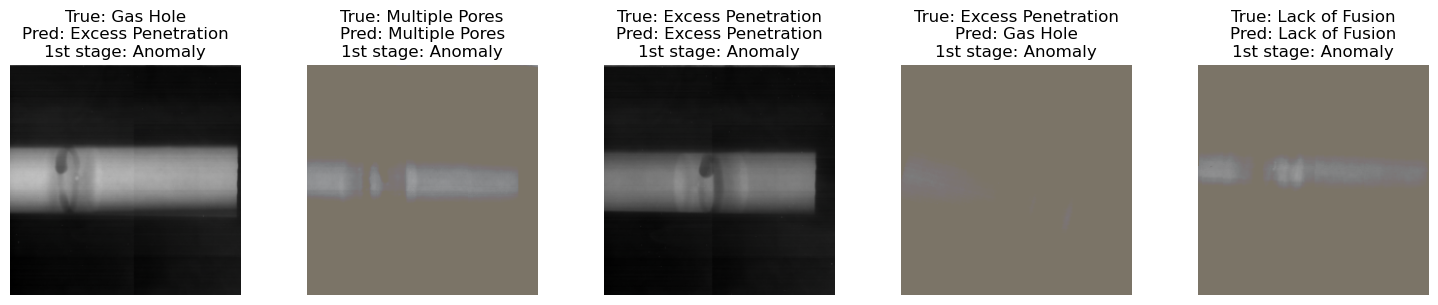


Visualizing predictions from the latest checkpoint:
Loaded checkpoint from: checkpoint.pth


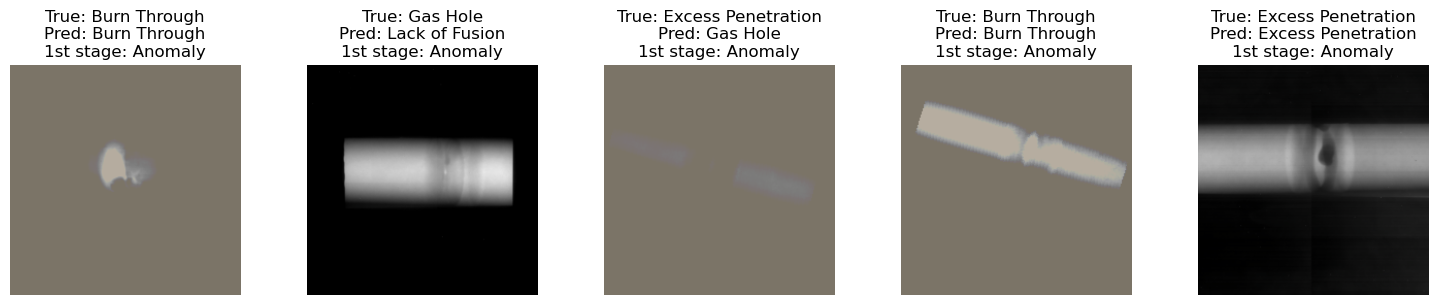


Generating confusion matrices for the best model:
Loaded checkpoint from: best_model.pth


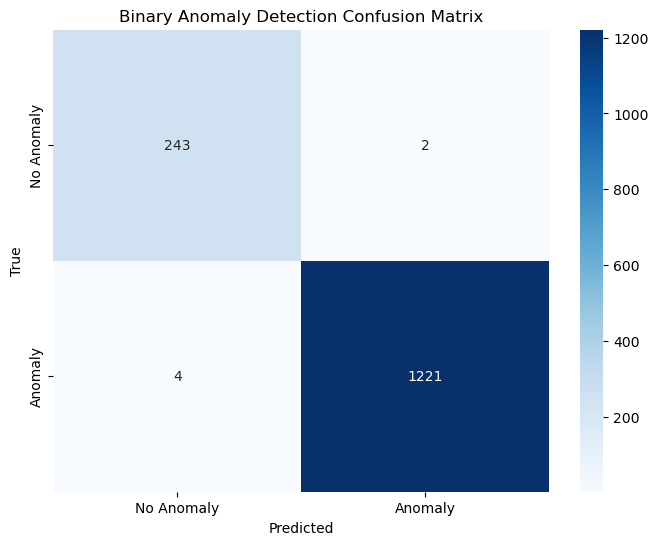

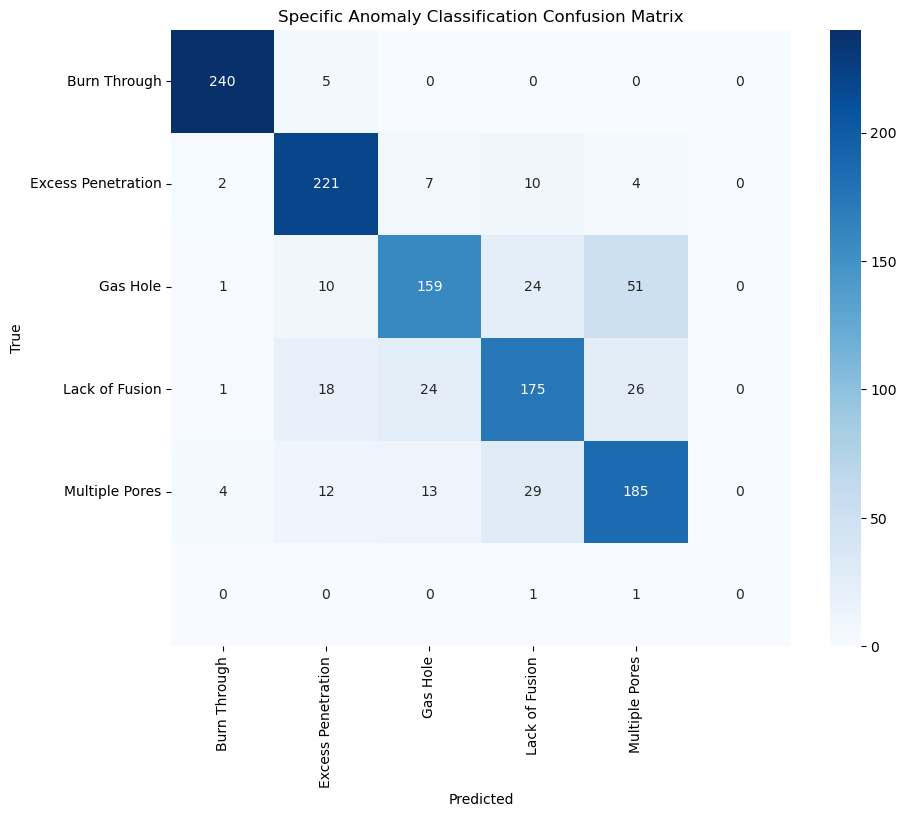


Generating confusion matrices for the latest checkpoint:
Loaded checkpoint from: checkpoint.pth


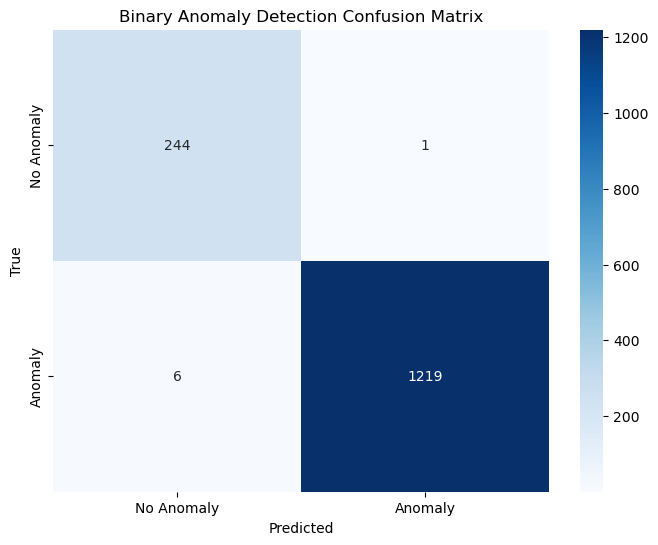

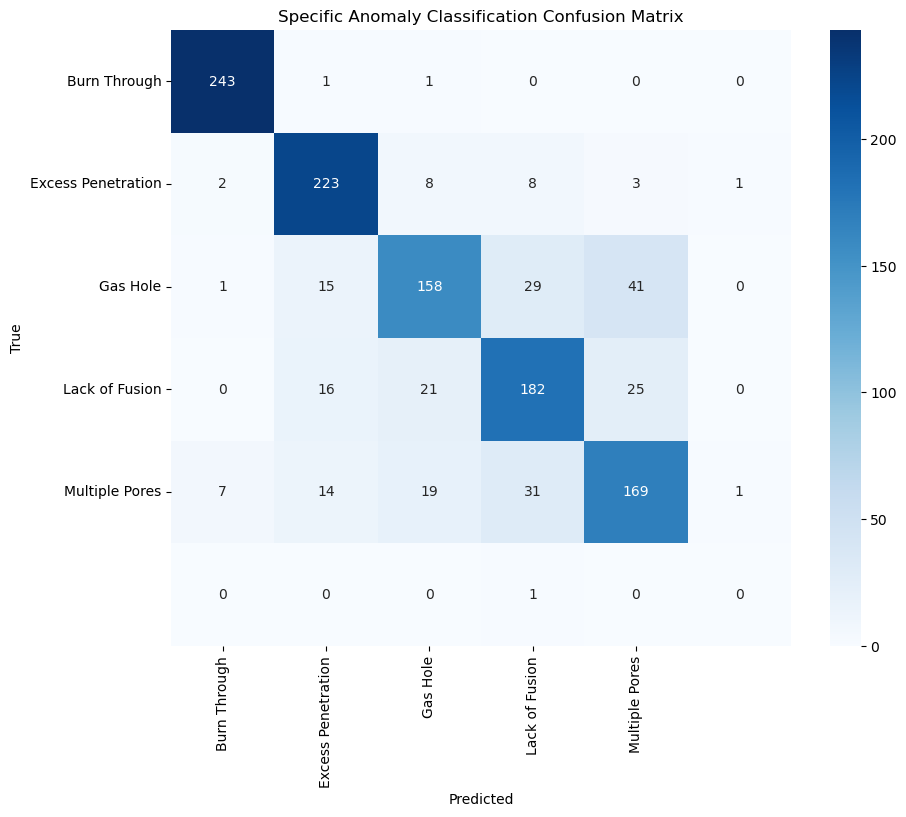

In [12]:
# Visualize predictions with optional checkpoint loading
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import random

def load_model_checkpoint(model, checkpoint_path):
    """Load a model checkpoint before visualization."""
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded checkpoint from: {checkpoint_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None
    return model

def visualize_predictions(model, test_loader, checkpoint_path=None, num_images=5):
    """Visualize randomly chosen predictions from the test set, optionally loading a checkpoint."""
    if checkpoint_path:
        model = load_model_checkpoint(model, checkpoint_path)
    
    model.eval()
    
    # Convert test dataset to a list and select random samples
    test_data = list(test_loader.dataset)
    selected_samples = random.sample(test_data, num_images)
    
    images, labels, anomaly_labels = zip(*[(img, label, anomaly) for img, label, anomaly in selected_samples])
    
    # Convert images to tensor batch
    images = torch.stack(images).to(device)
    
    # Get predictions
    with torch.no_grad():
        anomaly_outputs, specific_outputs = model(images)
        _, anomaly_preds = torch.max(anomaly_outputs, 1)
        _, specific_preds = torch.max(specific_outputs, 1)
    
    # Move back to CPU for visualization
    images = images.cpu()
    labels = torch.tensor(labels).cpu()
    anomaly_labels = torch.tensor(anomaly_labels).cpu()
    anomaly_preds = anomaly_preds.cpu()
    specific_preds = specific_preds.cpu()
    
    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # Convert image for display
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Get class names
        true_class = dataset.classes[labels[i]]
        pred_class = dataset.classes[specific_preds[i]]
        anomaly_true = "Anomaly" if anomaly_labels[i] == 1 else "No Anomaly"
        anomaly_pred = "Anomaly" if anomaly_preds[i] == 1 else "No Anomaly"
        
        # Display
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_class}\nPred: {pred_class}\n1st stage: {anomaly_pred}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate confusion matrices for anomaly detection and specific anomaly classification
def plot_confusion_matrices(model, test_loader, checkpoint_path=None):
    """Plot confusion matrices for binary anomaly detection and specific anomaly classification."""
    if checkpoint_path:
        model = load_model_checkpoint(model, checkpoint_path)
    
    model.eval()
    all_anomaly_preds, all_anomaly_labels = [], []
    all_specific_preds, all_specific_labels = [], []
    
    with torch.no_grad():
        for images, labels, anomaly_labels in test_loader:
            images = images.to(device)
            anomaly_outputs, specific_outputs = model(images)
            
            _, anomaly_preds = torch.max(anomaly_outputs, 1)
            _, specific_preds = torch.max(specific_outputs, 1)
            
            all_anomaly_preds.extend(anomaly_preds.cpu().numpy())
            all_anomaly_labels.extend(anomaly_labels.numpy())
            
            # Only consider predictions when anomaly is detected (to analyze specific class predictions)
            for i in range(len(anomaly_preds)):
                if anomaly_preds[i] == 1:  # If model detects an anomaly
                    all_specific_preds.append(specific_preds[i].cpu().numpy())
                    all_specific_labels.append(labels[i].cpu().numpy())
    
    # Binary Anomaly Detection Confusion Matrix
    cm_anomaly = confusion_matrix(all_anomaly_labels, all_anomaly_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_anomaly, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["No Anomaly", "Anomaly"],
                yticklabels=["No Anomaly", "Anomaly"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Binary Anomaly Detection Confusion Matrix')
    plt.show()

    # Specific Anomaly Classification Confusion Matrix (only within detected anomalies)
    cm_specific = confusion_matrix(all_specific_labels, all_specific_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_specific, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.anomaly_classes,
                yticklabels=dataset.anomaly_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Specific Anomaly Classification Confusion Matrix')
    plt.show()

best_model_path = hyperparams["best_model_path"]
checkpoint_path = hyperparams["checkpoint_path"]

print("Visualizing predictions from the best model:")
visualize_predictions(model, test_loader, best_model_path)

print("\nVisualizing predictions from the latest checkpoint:")
visualize_predictions(model, test_loader, checkpoint_path)

print("\nGenerating confusion matrices for the best model:")
plot_confusion_matrices(model, test_loader, best_model_path)

print("\nGenerating confusion matrices for the latest checkpoint:")
plot_confusion_matrices(model, test_loader, checkpoint_path)
